## Machine Learning Regression
The most obvious approach for predicting extraordinary material property values is a regression. Regression tools are widely used in the scientific community, and are the standard for predicting continues properties. For this we chose to model our data using 3 well-known algorithms: ridge regression, support vector regression, and random forest regression. We use the training data to perform grid search optimization, from which the best performing parameters are taken to get a prediction on the test set for each algorithm. Following these regressions, we evaluate the usefulness of our model using a prediction cutoff (predicted values above 280 are considered extraordinary). This naturally leads to classification metrics such as precision and recall which we use to compare models.

In [1]:
# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# import machine learning libraries
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from matplotlib.colors import Normalize

# import model selection tools
from sklearn.model_selection import cross_validate, cross_val_score,\
                                    cross_val_predict, learning_curve, \
                                    GridSearchCV, KFold

# grab metrics to evaluate our models
from sklearn.metrics import confusion_matrix, classification_report,\
                            r2_score, mean_squared_error, precision_recall_fscore_support

# import custom functions for vectorizing & visualizing data
import composition
import utils

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
pcd = False


mat_prop = 'agl_thermal_conductivity_300K'


train_threshold = 18
test_threshold = 25

### Import CSV files

In [2]:
X_train = pd.read_csv('data/'+mat_prop+'X_train.csv')
X_train_scaled = pd.read_csv('data/'+mat_prop+'X_train_scaled.csv')
y_train = pd.read_csv('data/'+mat_prop+'y_train.csv', header=None, squeeze=True)
y_train_labeled = pd.read_csv('data/'+mat_prop+'y_train_labeled.csv', header=None, squeeze=True)

X_test = pd.read_csv('data/'+mat_prop+'X_test.csv')
X_test_scaled = pd.read_csv('data/'+mat_prop+'X_test_scaled.csv')
y_test = pd.read_csv('data/'+mat_prop+'y_test.csv', header=None, squeeze=True)
y_test_labeled = pd.read_csv('data/'+mat_prop+'y_test_labeled.csv', header=None, squeeze=True)

formula_train = pd.read_csv('data/'+mat_prop+'formula_train.csv', header=None, squeeze=True)
formula_test = pd.read_csv('data/'+mat_prop+'formula_test.csv', header=None, squeeze=True)

if pcd is True:
    X_pcd = pd.read_csv('pcd_data/X_pcd.csv')
    X_pcd_scaled = pd.read_csv('pcd_data/X_pcd_scaled.csv')
    formula_pcd = pd.read_csv('pcd_data/formula_pcd.csv', header=None, squeeze=True)

plt.rcParams.update({'font.size': 12})

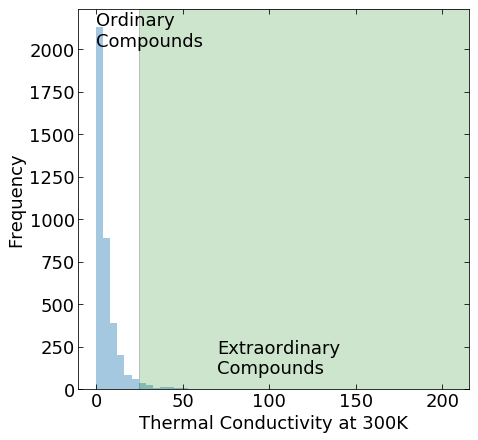

In [18]:
y = pd.concat([y_train, y_test])
plt.figure(1, figsize=(7, 7))

ax = sns.distplot(y, bins=50, kde=False)

rect1 = patches.Rectangle((test_threshold, 0), ax.get_xlim()[1]-test_threshold, ax.get_ylim()[1], linewidth=1, edgecolor='k', facecolor='g', alpha=0.2)
ax.add_patch(rect1)

text_size = 18

ax.text(0, ax.get_ylim()[1]-220, 'Ordinary\nCompounds', size=text_size)
ax.text(test_threshold+(ax.get_xlim()[1]-test_threshold)//2-50, 90, 'Extraordinary\nCompounds', size=text_size)
ax.tick_params(direction='in', length=5, bottom=True, top=True, left=True, right=True, labelsize=text_size)
ax.set_xlabel('Thermal Conductivity at 300K', size=text_size)
ax.set_ylabel('Frequency', size=text_size)
plt.savefig('figures/distplot', dpi=300, bbox_inches='tight')

## Learn with a Ridge Regression (linear model)

best parameters: {'alpha': 0.0774263682681127}


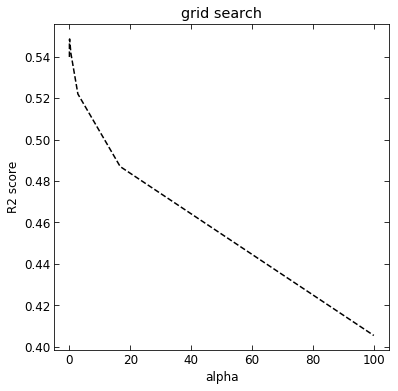

In [4]:
# define ridge regression object
rr = Ridge()
# define k-folds
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# choose search space
parameter_candidates = {'alpha': np.logspace(-5, 2, 10)}

# define the grid search
grid = GridSearchCV(estimator=rr,
                    param_grid=parameter_candidates,
                    cv=cv)
# run grid search
grid.fit(X_train_scaled, y_train)

# plot grid search to ensure good values)
plot = utils.plot_1d_grid_search(grid, midpoint=0.75)
print('best parameters:', grid.best_params_)
plt.savefig('figures/rr_1d_search', dpi=300, bbox_inches='tight')
best_params_rr = grid.best_params_

From the figure above, we can see that adding regularization to the ridge regression leads to worse performance. Regularization has the effect of reducing model complexity by limiting the magnitude of the coefficients we use in the regression. In other words, higher regularization restricts our model to a lower learning capacity. In our case, limiting the extent of regularization improves the model. This indicates that the model improves from capturing more complex relationships that exist in the data.

### Now that we know the best parameter, lets see how our model performs.

We can see that the test set has a low $R^2$. Moreover, we see that this regression simply cannot extrapolate above $\kappa=300$. Not all is lost however, if we draw threshold for determining extraordinary compounds, we can identify many of them by looking at the top X% of predicted values from the test set. We can generate metrics to represent model performance using these thresholds.

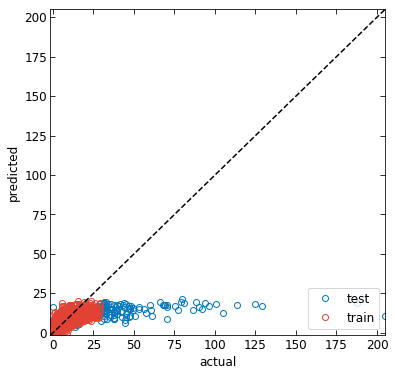

In [5]:
best_params_rr = {'alpha': 0.0021544346900318843}
rr = Ridge(**best_params_rr)
rr.fit(X_train_scaled, y_train)
y_test_predicted_rr = rr.predict(X_test_scaled)
y_train_predicted_rr = rr.predict(X_train_scaled)
# plot the data
plt.figure(figsize=(6,6))
plt.plot(y_test, y_test_predicted_rr, marker='o', mfc='none', color='#0077be', linestyle='none', label='test')
plt.plot(y_train, y_train_predicted_rr, marker='o', mfc='none', color='#e34234', linestyle='none', label='train')
max_val = max(y_test.max(), y_test_predicted_rr.max())
min_val = min(y_test.min(), y_test_predicted_rr.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
limits = [min_val, max_val]
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend(loc=4)
plt.tick_params(direction='in', length=5, bottom=True, top=True, left=True, right=True)
plt.savefig('figures/rr_act_vs_pred', dpi=300, bbox_inches='tight')

You can see that the train and test predictions are not significantly different. This is generally due to the model not having sufficient capacity to learn the desired property with the given inputs. This indicates that we may find better performance using more complex non-linear models. A support vector regression allows us to learn from data in a non-linear space. This often leads to better performance and is a great candidate for our next model. Other approaches might include a random forest algorithm or neural networks. However, random forest models performed poorly on preliminary testing and we deemed a neural network as overly complex for our purposes.

## Learn with a support vector regression (non-linear model)

best parameters: {'C': 372.7593720314938, 'gamma': 0.0517947467923121}


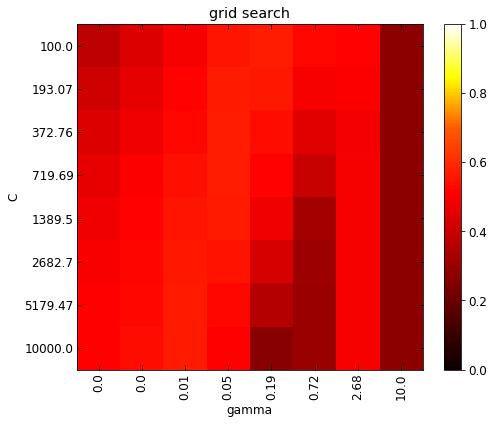

In [6]:
# to speed up the grid search, optimize on a subsample of data
X_train_scaled_sampled = X_train_scaled.sample(1500, random_state=1)
y_train_sampled = y_train.loc[X_train_scaled_sampled.index.values]

# define support vector regression object (default to rbf kernel)
svr = SVR()
# define k-folds
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# choose search space
parameter_candidates = {'C': np.logspace(2, 4, 8), 'gamma': np.logspace(-3, 1, 8)}

# define the grid search
grid = GridSearchCV(estimator=svr,
                    param_grid=parameter_candidates,
                    cv=cv)
# run grid search
grid.fit(X_train_scaled_sampled, y_train_sampled)

# plot grid search to ensure good values
utils.plot_2d_grid_search(grid, midpoint=0.7)
plt.savefig('figures/svr_2d_search', dpi=300, bbox_inches='tight')
print('best parameters:', grid.best_params_)
best_params_svr = grid.best_params_

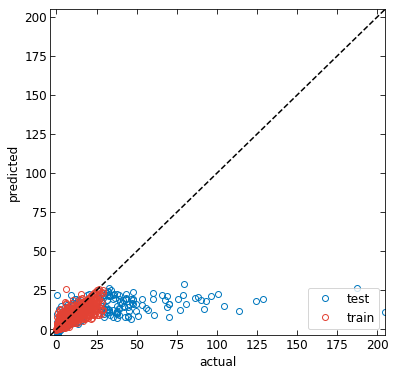

In [7]:
best_params_svr = {'C': 1389.4954943731375, 'gamma': 0.19306977288832497}
svr = SVR(**best_params_svr)
svr.fit(X_train_scaled, y_train)

y_test_predicted_svr = svr.predict(X_test_scaled)
y_train_predicted_svr = svr.predict(X_train_scaled)

# plot the data
plt.figure(figsize=(6,6))
plt.plot(y_test, y_test_predicted_svr, marker='o', mfc='none', color='#0077be', linestyle='none', label='test')
plt.plot(y_train, y_train_predicted_svr, marker='o', mfc='none', color='#e34234', linestyle='none', label='train')

max_val = max(y_test.max(), y_test_predicted_svr.max())
min_val = min(y_test.min(), y_test_predicted_svr.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
limits = [min_val, max_val]
plt.xlim(limits)
plt.ylim(limits)

plt.xlabel('actual')
plt.ylabel('predicted')
plt.legend(loc=4)
plt.tick_params(direction='in', length=5, bottom=True, top=True, left=True, right=True)
plt.savefig('figures/svr_act_vs_pred', dpi=300, bbox_inches='tight')

The performance of the test data, shown above in blue, is not optimal. In the case of both a ridge and support vector regression, we fail to capture the behavior without introducing significant spread in the predicted versus actual values. This is especially true with higher value compounds. This is unfortunate, as these are the target compounds for succesful extrapolation. Rather than looking for compounds with values predicted beyond the training set, we can succesfully extrapolate by introducing heuritics to aid in our search. For example, consider all compounds predicted above 250 GPa as being extraordinary. This is effectivley the same as a classification task, as we are choosing a threshold, and relabeling our data as ordinary/extraordinary. 

In that case, let us restructure the problem as a classification from the start.

# Approach the problem as a classification task

## Learn with a logistic regression (linear classification) 

best parameters: {'C': 31.622776601683793, 'class_weight': {0: 1, 1: 1.0}}


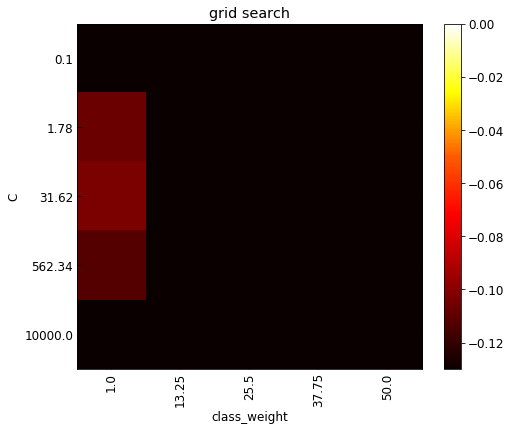

In [8]:
# define logistic regression object
lr = LogisticRegression()
# define k-folds
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# choose search space
class_weights = []
class_1_weight = [{0:1, 1:weight} for weight in np.linspace(1, 50, 5)]
parameter_candidates = {'C': np.logspace(-1, 4, 5), 
                        'class_weight': class_1_weight}

# define the grid search. We use log-loss to decide which parameters to use.
grid = GridSearchCV(estimator=lr,
                    param_grid=parameter_candidates,
                    scoring='neg_log_loss',
                    cv=cv)

# run grid search
grid.fit(X_train_scaled, y_train_labeled)

# plot grid search to ensure good values
utils.plot_2d_grid_search(grid, midpoint=-0.05, vmin=-0.13, vmax=0)
plt.savefig('figures/lr_2d_search', dpi=300, bbox_inches='tight')
print('best parameters:', grid.best_params_)
best_params_lr = grid.best_params_

## Precision and Recall for understanding prediction metrics

$$
precision = \frac{tp}{tp+fp} = \frac{\text{# correct}}{\text{# predicted as extraordinary}}
$$


$$
recall = \frac{tp}{fn+tp} = \frac{\text{# identified}}{\text{# of extraordinary compounds}}
$$


This is important as it gives us expected performance on our predictions. Lets look at the best mean-cross-validation values from the logitic regression. Looking at the individual metrics of the F score, we can expect that for every ten compounds we predict as extraordinary, about four of them will actually be extraordinary ($precision=X$). Similarly, we expect to be able to identify 80 out of every 100 extraordinary materials that exists (recall=X).

-----

With this in mind, lets look at how well our training set performs, then we will check out the test set.

[]

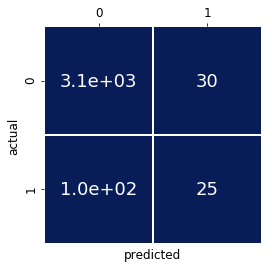

In [9]:
best_params_lr = {'C': 31.622776601683793, 'class_weight': {0: 1, 1: 1.0}}
lr = LogisticRegression(penalty='l2', **best_params_lr)
lr.fit(X_train_scaled, y_train_labeled)

# define k-folds
cv = KFold(n_splits=5, shuffle=True, random_state=1)

y_pred_train_lr = cross_val_predict(lr, X_train_scaled, y_train_labeled, cv=cv)
y_prob_train_lr = cross_val_predict(lr, X_train_scaled, y_train_labeled, cv=cv, method='predict_proba')
y_probability_train_lr = [probability[1] for probability in y_prob_train_lr]

y_pred_test_lr = lr.predict(X_test_scaled)
y_prob_test_lr = lr.predict_proba(X_test_scaled)
y_probability_test_lr = [probability[1] for probability in y_prob_test_lr]

df_cm = pd.DataFrame(confusion_matrix(y_train_labeled, y_pred_train_lr))

ax = sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 18}, cbar=False, linewidths=.5, cmap="YlGnBu", center=-10000000)

ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.xaxis.tick_top()
plt.savefig('figures/lr_cm', dpi=300, bbox_inches='tight')
plt.plot()

precision: 0.45
recall: 0.19


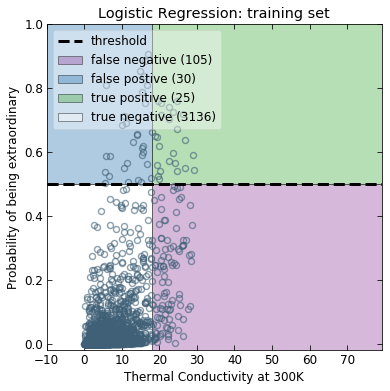

In [10]:
threshold = 0.5
utils.plot_prob(threshold, y_train, y_probability_train_lr, threshold_x=train_threshold)
plt.title('Logistic Regression: training set')
plt.savefig('figures/lr_train_prob_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

Using the default threshold of 0.5, we can see that about half of the extraordinary materials are not classified correctly. If the goal is to find an extraordinary material with the fewest number of trials, than this labeling works well as it maximimzed the precision at the expense of the recall. 

However, we are not limited to using 0.5 as our threshold cut-off. We see that we can capture many more extraodrinary materials by considereing compounds with lower probabilities of having high material property values (eg. exchange precision for recall). We illustrate this bellow by changing the threshold from 0.5 to 0.25. This allows us to identify significantly more extraordinary materials without adding too many false positives.

precision: 0.43
recall: 0.48


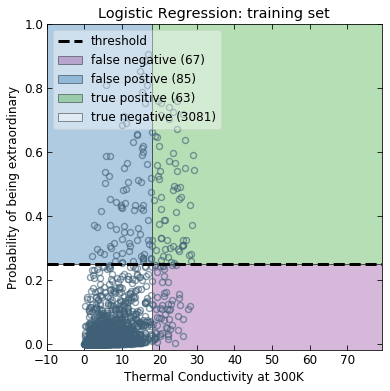

In [11]:
threshold = 0.25
utils.plot_prob(threshold, y_train, y_probability_train_lr, threshold_x=train_threshold)
plt.title('Logistic Regression: training set')
plt.savefig('figures/lr_train_prob_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

### Check our perfromance on the test set!

C:\Users\Com\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


precision: 0.00
recall: 0.00


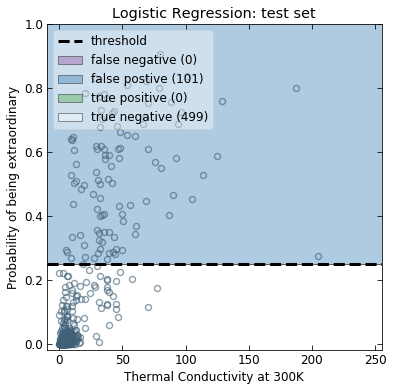

In [12]:
threshold = 0.25
utils.plot_prob(threshold, y_test, y_probability_test_lr)
plt.title('Logistic Regression: test set')
plt.savefig('figures/lr_test_prob_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

### Compare this performance to regression models

**For the same recall, we are three times more likely that predicted compound is not actually extraordinary.**

precision: 0.50
recall: 0.11


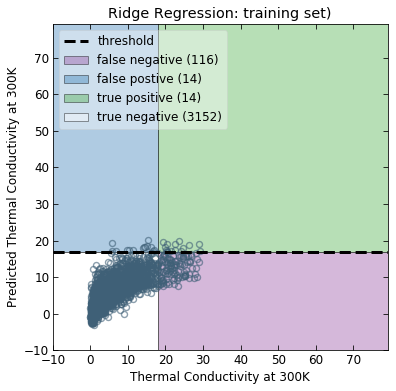

In [13]:
threshold = 17
utils.plot_regression(threshold, y_train, y_train_predicted_rr, threshold_x=train_threshold)
plt.title('Ridge Regression: training set)')
plt.savefig('figures/rr_train_reg_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

precision: 0.92
recall: 0.33


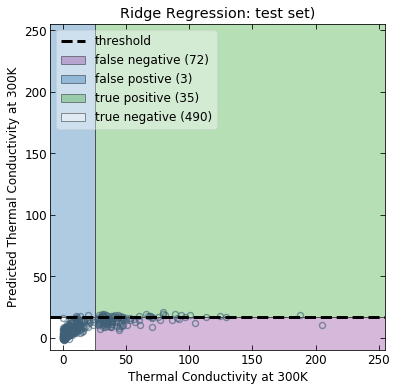

In [14]:
threshold = 17
utils.plot_regression(threshold, y_test, y_test_predicted_rr, threshold_x=test_threshold)
plt.title('Ridge Regression: test set)')
plt.savefig('figures/rr_test_reg_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

precision: 0.59
recall: 0.58


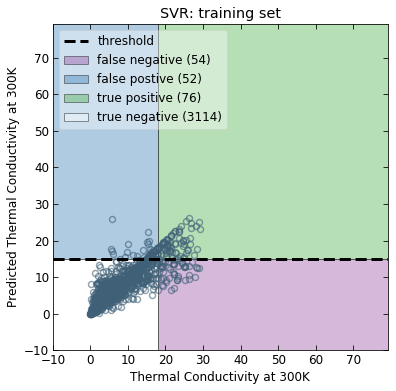

In [15]:
threshold = 15
utils.plot_regression(threshold, y_train, y_train_predicted_svr, threshold_x=train_threshold)
plt.title('SVR: training set')
plt.savefig('figures/svr_train_reg_thresh={:0.02f}.png'.format(threshold), dpi=300, bbox_inches='tight')

precision: 0.77
recall: 0.59


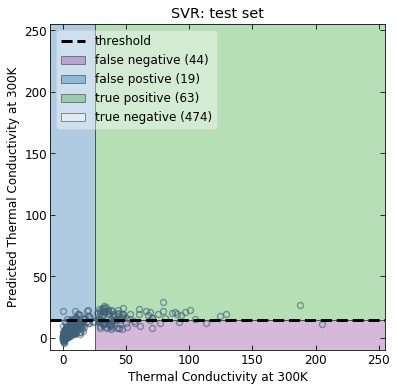

In [21]:
threshold = 15
utils.plot_regression(threshold, y_test, y_test_predicted_svr, threshold_x=test_threshold)
plt.title('SVR: test set')
plt.savefig('figures/svr_test_reg_thresh={:0.02f}.png'.format(threshold), dpi=300, bbox_inches='tight')

## Learn with a support vector classification (non-linear)

best parameters: {'C': 562.341325190349, 'gamma': 0.01}


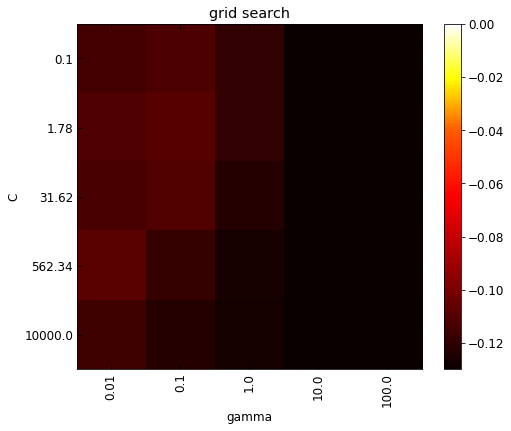

In [22]:
# to speed up the grid search, optimize on a subsample of data 
# need a larger sample since the true label is infrequent
X_train_scaled_sampled = X_train_scaled.sample(1500, random_state=1)
y_train_labeled_sampled = y_train_labeled.loc[X_train_scaled_sampled.index.values]

# define suppor vector classification object (need to set probability to True)
svc = SVC(probability=True)
# define k-folds
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# choose search space (we will start with class_weight=1 
# as that was optimal for svc)
parameter_candidates = {'C': np.logspace(-1, 4, 5), 
                        'gamma': np.logspace(-2, 2, 5)}

# define the grid search. We use log-loss to decide which parameters to use.
grid = GridSearchCV(estimator=svc,
                    param_grid=parameter_candidates,
                    scoring='neg_log_loss',
                    cv=cv)

# run grid search
grid.fit(X_train_scaled_sampled, y_train_labeled_sampled)

# plot grid search to ensure good values
utils.plot_2d_grid_search(grid, midpoint=-0.04, vmin=-0.13, vmax=0)
plt.savefig('figures/svc_2d_search.png', dpi=300, bbox_inches='tight')
print('best parameters:', grid.best_params_)
best_params_svc = grid.best_params_

precision: 0.46
recall: 0.30


[]

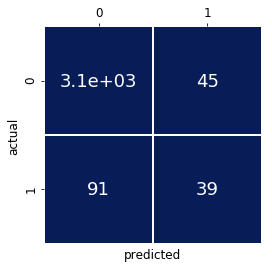

In [23]:
best_params_svc = {'C': 562.341325190349, 'gamma': 0.1}
svc = SVC(probability=True, **best_params_svc)
svc.fit(X_train_scaled, y_train_labeled)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

y_pred_train_svc = cross_val_predict(svc, X_train_scaled, y_train_labeled, cv=cv)
y_prob_train_svc = cross_val_predict(svc, X_train_scaled, y_train_labeled, cv=cv, method='predict_proba')
y_probability_train_svc = [probability[1] for probability in y_prob_train_svc]

y_pred_test_svc = svc.predict(X_test_scaled)
y_prob_test_svc = svc.predict_proba(X_test_scaled)
y_probability_test_svc = [probability[1] for probability in y_prob_test_svc]

precision, recall, fscore, support = precision_recall_fscore_support(y_train_labeled, y_pred_train_svc)
print('precision: {:0.2f}\nrecall: {:0.2f}'.format(precision[1], recall[1]))
df_cm = pd.DataFrame(confusion_matrix(y_train_labeled, y_pred_train_svc))

ax = sns.heatmap(df_cm, square=True, annot=True, annot_kws={"size": 18}, cbar=False, linewidths=.5, cmap="YlGnBu", center=-10000000)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.xaxis.tick_top()
plt.savefig('figures/svc_cm', dpi=300, bbox_inches='tight')
plt.plot()

precision: 0.27
recall: 0.03


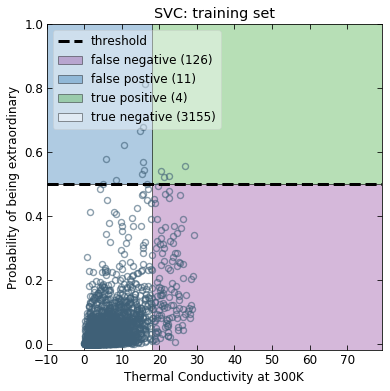

In [24]:
threshold = 0.5
utils.plot_prob(threshold, y_train, y_probability_train_svc, threshold_x=train_threshold)
plt.title('SVC: training set')
plt.savefig('figures/svc_train_prob_thresh={:0.02f}.png'.format(threshold), dpi=300, bbox_inches='tight')

precision: 0.39
recall: 0.35


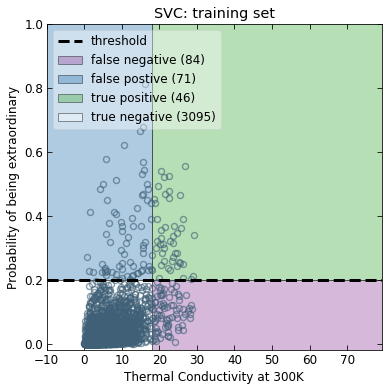

In [25]:
threshold = 0.2
utils.plot_prob(threshold, y_train, y_probability_train_svc, threshold_x=train_threshold)
plt.title('SVC: training set')
plt.savefig('figures/svc_train_prob_thresh={:0.02f}.png'.format(threshold), dpi=300, bbox_inches='tight')

C:\Users\Com\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


precision: 0.00
recall: 0.00


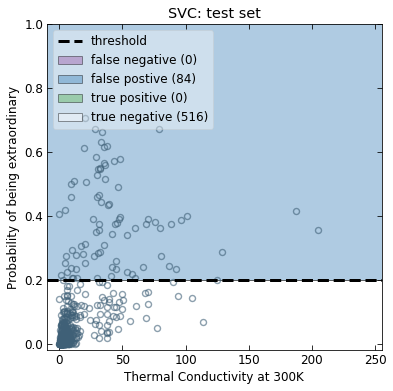

In [26]:
threshold = 0.2
utils.plot_prob(threshold, y_test, y_probability_test_svc)
plt.title('SVC: test set')
plt.savefig('figures/svc_test_prob_thresh={:0.2f}.png'.format(threshold), dpi=300, bbox_inches='tight')

# 6. Bonus Material: generating predictions from the PCD

### You will need the PCD data (available by email). You will also need to set pcd=True in first cell.

In [27]:
if pcd is True:
    X_all_scaled = pd.concat([X_train_scaled, X_test_scaled], ignore_index=True)
    y_all = pd.concat([y_train, y_test], ignore_index=True)
    formula_all = pd.concat([formula_train, formula_test], ignore_index=True)

    y_all_labeled = []
    for value in y_all:
        if value > 275:
            y_all_labeled.append(1)
        else:
            y_all_labeled.append(0)
    y_all_labeled = pd.Series(y_all_labeled)
    print(y_all_labeled.value_counts())

    best_params_svc = {'C': 562.341325190349, 'gamma': 0.1}
    svc_all = SVC(probability=True, **best_params_svc, random_state=1)
    svc_all.fit(X_all_scaled, y_all_labeled)

    best_params_lr = {'C': 31.622776601683793, 'class_weight': {0: 1, 1: 1.0}}
    lr_all = LogisticRegression(**best_params_lr, random_state=1)
    lr_all.fit(X_all_scaled, y_all_labeled)

    y_prob_pcd_svc = svc_all.predict_proba(X_pcd_scaled)
    y_prob_pcd_lr = lr_all.predict_proba(X_pcd_scaled)

    extraordinary_formulae_svc = []
    extraordinary_formulae_lr = []
    threshold = 0.25
    for prob, formula in zip(y_prob_pcd_svc, formula_pcd):
        if prob[1] >= threshold:
            extraordinary_formulae_svc.append(formula)

    for prob, formula in zip(y_prob_pcd_lr, formula_pcd):
        if prob[1] >= threshold:
            extraordinary_formulae_lr.append(formula)

    print('\n'+'# extraordinary compounds scv={:}'.format(len(extraordinary_formulae_svc)))
    print('# extraordinary compounds lr={:}'.format(len(extraordinary_formulae_lr)))

    def get_non_DFT_compounds(extraordinary_formulae):
        in_sample = []
        out_of_sample = []
        fractional_formula_all  = [composition._fractional_composition(formula) for formula in formula_all]
        for formula in extraordinary_formulae:
            fractional_formula = composition._fractional_composition(formula)
            if fractional_formula not in fractional_formula_all:
                out_of_sample.append(formula)
            else:
                in_sample.append(fractional_formula)
                in_sample.append(formula)
        return out_of_sample

    out_svc = get_non_DFT_compounds(extraordinary_formulae_svc)
    out_lr = get_non_DFT_compounds(extraordinary_formulae_lr)

    overlap = []
    for lr in out_lr:
        if lr in out_svc:
            overlap.append(lr)
    print('# of overlapping compounds:', len(overlap))

    print('\ncompounds of interest:', overlap)